In this section we will provide the results from four modeling approaches.  Three of these 
modeling approaches are defined for you, and you get to choose the fourth approach from the 
list of choices.   
    - For each model provide any relevant or useful model output and a table of the model
    performance in-sample (i.e. on the training data set) and out-of-sample (i.e. on the test data set).   
    - The metrics to be measured are:   
        (1) true positive rate or sensitivity  
        (2) false positive rate  
        (3) the accuracy.  
 
5.a Random Forest  
    - Include the variable importance plot.  
 
5.b Gradient Boosting  
    - Use GBM or XGBoost packages.  Include the variable importance plot.  

5.c Logistic Regression with Variable Selection   
    - Random Forest and Gradient Boosting will identify a pool of interesting predictor 
    variables.  Use that information to help you choose an initial pool of predictor variables.   
    List your initial pool of predictor variables in a table.   
    - Choose a variable selection algorithm.  Use that variable selection algorithm to arrive at 
    an ‘optimal’ logistic regression model.  
    - Since this is a linear model, you should provide a table of the model coefficients and 
    their p-values.  
 
5.d Your Choice – CHAID, Neural Network, SVM, or some other method appropriate for 
binary classification.   
    - Provide the relevant output for the model of choice.  For example SVM has margin 
    plots that are useful, and a neural network allows you to plot out the network topology.  If 
    your chosen method has a ‘standard’ plot that is typically shown with it, then we all 
    expect to see that plot, and you should be providing that plot with the model.

In [10]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [11]:
credit_card_default_raw = pd.read_csv('./Data/credit_card_default.csv')
result = pyreadr.read_r('./Data/credit_card_default_eng.RData') 
credit_card_default_eng = result[None]

In [12]:

display(credit_card_default_eng.describe())
display(credit_card_default_eng.head())

,DEFAULT,bill_avg,payment_avg,pay_ratio1,pay_ratio2,pay_ratio3,pay_ratio4,pay_ratio5,ratio_avg,util1,util2,util3,util4,util5,util6,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000
mean,0.221200,44976.945200,5275.232094,0.579660,0.767499,0.583088,0.439289,0.512580,0.576423,0.423771,0.411128,0.392192,0.359503,0.333108,0.333108,0.375468,-0.090664,6.057244e+04,1.584823e+04,0.682200
std,0.415062,63260.721860,10137.946323,25.679778,38.681092,25.683585,1.196318,5.075522,16.499616,0.411462,0.404555,0.396449,0.368686,0.350542,0.350542,0.355618,0.279674,7.840481e+04,3.793356e+04,1.073518
min,0.000000,-56043.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.619892,-1.395540,-1.025100,-1.374500,-0.876743,-0.876743,-0.232590,-4.700400,-6.029000e+03,0.000000e+00,0.000000
25%,0.000000,4781.333333,1113.291667,0.044674,0.044607,0.037923,0.036397,0.038092,0.047855,0.022032,0.018318,0.016030,0.014299,0.011133,0.011133,0.028925,-0.146863,1.006000e+04,2.198000e+03,0.000000
50%,0.000000,21051.833333,2397.166667,0.101535,0.103755,0.084352,0.076952,0.090388,0.197668,0.313994,0.296057,0.273135,0.242066,0.212026,0.212026,0.286554,-0.004382,3.120850e+04,5.000000e+03,0.000000
75%,0.000000,57104.416667,5583.916667,1.000000,1.000000,1.000000,1.000000,1.000000,0.903817,0.829843,0.806500,0.755107,0.667937,0.602245,0.602245,0.692718,0.028105,7.959900e+04,1.210000e+04,2.000000
max,1.000000,877313.833333,627344.333333,4444.333333,5001.000000,4444.333333,129.705128,690.655172,2667.199955,6.455300,6.380500,10.688575,5.146850,4.935500,4.935500,5.537758,1.791100,1.664089e+06,1.684259e+06,8.000000


,DEFAULT,age_bins,bill_avg,payment_avg,pay_ratio1,pay_ratio2,pay_ratio3,pay_ratio4,pay_ratio5,ratio_avg,util1,util2,util3,util4,util5,util6,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
0,1,21-30,1284.000000,114.833333,0.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.195650,0.155100,0.034450,0.000000,0.000000,0.000000,0.064200,-0.195650,3913,689,2.0
1,1,21-30,2846.166667,833.333333,0.000000,0.372856,0.305623,0.289436,0.000000,0.193583,0.022350,0.014375,0.022350,0.027267,0.028792,0.028792,0.023987,0.006442,3455,2000,2.0
2,0,31-40,16942.166667,1836.333333,0.108220,0.110628,0.069779,0.066899,0.064313,0.083968,0.324878,0.155856,0.150656,0.159233,0.166089,0.166089,0.187133,-0.158789,29239,5000,0.0
3,0,31-40,38555.666667,1398.000000,0.041465,0.040961,0.042382,0.037985,0.036180,0.039794,0.939800,0.964660,0.985820,0.566280,0.579180,0.579180,0.769153,-0.360620,49291,2019,0.0
4,0,51-60,18223.166667,9841.500000,0.352734,1.023608,0.477555,0.470072,0.036015,0.471997,0.172340,0.113400,0.716700,0.418800,0.382920,0.382920,0.364513,0.210580,35835,36681,0.0


In [13]:
credit_card_default_eng.dtypes

DEFAULT                  int32
age_bins              category
bill_avg               float64
payment_avg            float64
pay_ratio1             float64
pay_ratio2             float64
pay_ratio3             float64
pay_ratio4             float64
pay_ratio5             float64
ratio_avg              float64
util1                  float64
util2                  float64
util3                  float64
util4                  float64
util5                  float64
util6                  float64
util_avg               float64
balance_growth_6mo     float64
bill_max                 int32
payment_max              int32
pay_max                float64
dtype: object

In [14]:
# clean data
credit_card_default = credit_card_default_eng.copy()
df_flags = credit_card_default_raw['data.group']
credit_card_default = credit_card_default.join(df_flags)

# credit_card_default['age_bins'].replace({
#       '21-30': 1
#     , '31-40': 2
#     , '51-60': 3
#     , '41-50': 4
#     , '61-70': 5
#     , '71-80': 6
# }, inplace=True)

In [15]:
ccd_train = credit_card_default[credit_card_default['data.group']==1].drop(columns='data.group')
ccd_test = credit_card_default[credit_card_default['data.group']==2].drop(columns='data.group')
ccd_validate = credit_card_default[credit_card_default['data.group']==3].drop(columns='data.group')

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (15180, 21)
test data size: (7323, 21)
validate data size: (7497, 21)


In [16]:
X = credit_card_default.drop(columns='data.group')
X_train_official = ccd_train.drop(columns='DEFAULT')
X_train = ccd_train.drop(columns='DEFAULT')
X_test_official = ccd_test.drop(columns='DEFAULT')
X_test = ccd_test.drop(columns='DEFAULT')

y = credit_card_default['DEFAULT']
y_train_official = ccd_train['DEFAULT']
y_train = ccd_train['DEFAULT']
y_test_official = ccd_test['DEFAULT']
y_test = ccd_test['DEFAULT']

Prep for modeling

In [17]:
all_features = credit_card_default_eng.columns
all_features = all_features.tolist()

In [18]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['bill_avg',
 'payment_avg',
 'pay_ratio1',
 'pay_ratio2',
 'pay_ratio3',
 'pay_ratio4',
 'pay_ratio5',
 'ratio_avg',
 'util1',
 'util2',
 'util3',
 'util4',
 'util5',
 'util6',
 'util_avg',
 'balance_growth_6mo',
 'bill_max',
 'payment_max',
 'pay_max']

['age_bins']

In [19]:
### we've done our own splitting

# #import train_test_split library
# from sklearn.model_selection import train_test_split

# # create train test split
# y_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [20]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [21]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )

5.a Model

In [22]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    #SimpleImputer(strategy = 'median'),
    KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),

)

preprocessor_best = make_pipeline(preprocessor,
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )

In [23]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import xgboost as xgb
# model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4, use_label_encoder=False)

XG_model = make_pipeline(preprocessor_best, XGBClassifier(n_estimators = 100))

In [24]:
%%time

# XG_model.fit(X_train, y_train)
XG_model.fit(X, y)

CPU times: total: 16.5 s
Wall time: 2.51 s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['bill_avg',
                                                                    'payment_avg',
                                                                    'pay_ratio1',
                                                                    'pay_ratio2',
                                                                    'pay_ratio3',
                                                                    'pay_ratio4',
                                                                    'pay_ratio5',
                                                                    'ratio_avg',
                                                                    'util1',
                                                                    'util2',
                                                                    'util3',
                                                                    'util4',
                                                                    'util5',
                                                                    'util...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [25]:
# XG_model.score(X_train, y_train)
XG_model.score(X, y)

0.8758666666666667

,precision,recall,f1-score,support
0,0.88,0.98,0.93,5766.00
1,0.87,0.52,0.65,1557.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.88,0.75,0.79,7323.00
weighted avg,0.88,0.88,0.87,7323.00


[[5646  120]
 [ 752  805]]


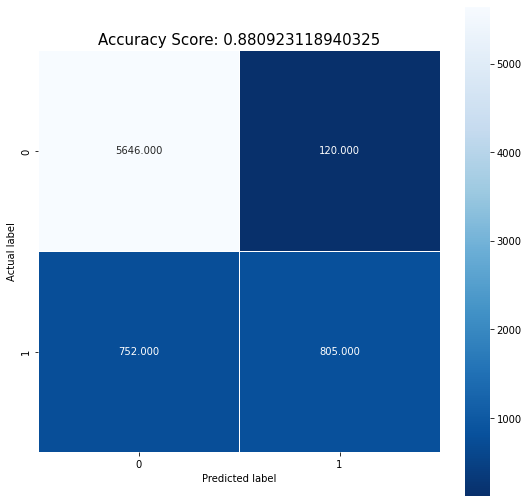

In [26]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = XG_model.predict(X_test)
score = XG_model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


Use K-fold

In [36]:
from sklearn.model_selection import KFold

In [37]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = make_pipeline(preprocessor_best, XGBClassifier(random_state=42, n_jobs=-1, **params))
    model.fit(X_train, train_targets)
    train_accuracy = model.score(X_train, train_targets)
    val_accuracy = model.score(X_val, val_targets)
    return model, train_accuracy, val_accuracy

In [38]:
kfold = KFold(n_splits=5)

In [39]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

Train Accuracy: 0.8117916666666667, Validation Accuracy: 0.7835
Train Accuracy: 0.8140416666666667, Validation Accuracy: 0.7851666666666667
Train Accuracy: 0.813375, Validation Accuracy: 0.7876666666666666
Train Accuracy: 0.8044583333333334, Validation Accuracy: 0.815
Train Accuracy: 0.8082083333333333, Validation Accuracy: 0.8038333333333333


In [40]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [41]:
preds = predict_avg(models, test.iloc[:, 1:31])

NameError: name 'test' is not defined

Hyperparameter tuning

In [42]:
def test_params_kfold(n_splits, **params):
    train_accuracys, val_accuracys, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
        model, train_accuracy, val_accuracy = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_accuracys.append(train_accuracy)
        val_accuracys.append(val_accuracy)
    print('Train accuracy: {}, Validation accuracy: {}'.format(np.mean(train_accuracys), np.mean(val_accuracys)))
    return models

n_estimators

In [43]:
%%time
test_params_kfold(5, n_estimators=10)

Train accuracy: 0.822875, Validation accuracy: 0.7934666666666667
CPU times: total: 14.1 s
Wall time: 3.19 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [45]:
test_params_kfold(5, n_estimators=100)

Train accuracy: 0.8911416666666666, Validation accuracy: 0.7884333333333333


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [46]:
test_params_kfold(5, n_estimators=240)

Train accuracy: 0.9458666666666666, Validation accuracy: 0.7845333333333333


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [47]:
%%time
test_params_kfold(5, n_estimators=500)

Train accuracy: 0.9823083333333333, Validation accuracy: 0.7821333333333333
CPU times: total: 8min 32s
Wall time: 1min 24s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

max_depth

In [48]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=2)

Train accuracy: 0.7934166666666667, Validation accuracy: 0.7915666666666666
CPU times: total: 5.89 s
Wall time: 1.07 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [49]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=4)

Train accuracy: 0.8054166666666667, Validation accuracy: 0.7947
CPU times: total: 8.09 s
Wall time: 1.45 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [50]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=6)

Train accuracy: 0.822875, Validation accuracy: 0.7934666666666667
CPU times: total: 11.5 s
Wall time: 1.93 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

learning_rate

In [51]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=4, learning_rate=0.01)

Train accuracy: 0.7951333333333334, Validation accuracy: 0.7912666666666667
CPU times: total: 7.8 s
Wall time: 1.32 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [52]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=4, learning_rate=0.1)

Train accuracy: 0.7996666666666667, Validation accuracy: 0.7943666666666667
CPU times: total: 7.5 s
Wall time: 1.35 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [53]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=4, learning_rate=0.3)

Train accuracy: 0.8054166666666667, Validation accuracy: 0.7947
CPU times: total: 7.66 s
Wall time: 1.36 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [54]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=4, learning_rate=0.9)

Train accuracy: 0.8109583333333333, Validation accuracy: 0.7926666666666666
CPU times: total: 7.58 s
Wall time: 1.32 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

In [55]:
%%time
test_params_kfold(5, n_estimators=10, max_depth=4, learning_rate=0.99)

Train accuracy: 0.8091999999999999, Validation accuracy: 0.7909
CPU times: total: 8.12 s
Wall time: 1.45 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['bill_avg',
                                                                     'payment_avg',
                                                                     'pay_ratio1',
                                                                     'pay_ratio2',
                                                                     'pay_ratio3',
 

optimal model:  
test_params_kfold(5, n_estimators=10, max_depth=4, learning_rate=0.3)

In [28]:
#Putting it all together
XG_model_with_paramter_tuning = make_pipeline(preprocessor_best, XGBClassifier(n_jobs=-1, random_state=42,
                                                                               n_estimators = 10,learning_rate=0.3, 
                                                                               max_depth=4))

XG_model_with_paramter_tuning.fit(X_train_official,y_train_official)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['bill_avg',
                                                                    'payment_avg',
                                                                    'pay_ratio1',
                                                                    'pay_ratio2',
                                                                    'pay_ratio3',
                                                                    'pay_ratio4',
                                                                    'pay_ratio5',
                                                                    'ratio_avg',
                                                                    'util1',
                                                                    'util2',
                                                                    'util3',
                                                                    'util4',
                                                                    'util5',
                                                                    'util...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.3, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=10, n_jobs=-1, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

In [29]:
XG_model.score(X_test_official, y_test_official)


0.8047248395466339

,precision,recall,f1-score,support
0,0.81,0.99,0.89,5766.0
1,0.72,0.13,0.22,1557.0
accuracy,0.80,0.80,0.80,0.8
macro avg,0.77,0.56,0.56,7323.0
weighted avg,0.79,0.80,0.75,7323.0


[[5688   78]
 [1352  205]]


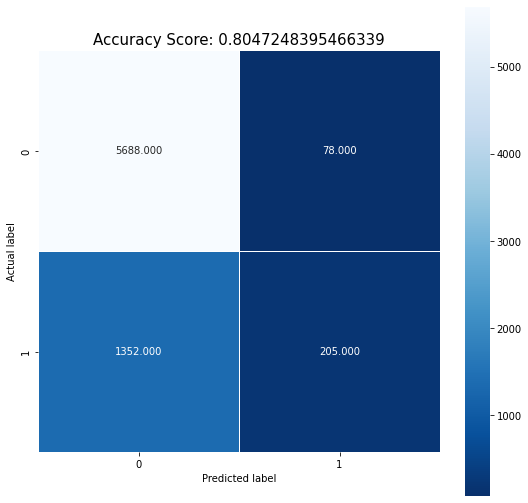

In [30]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = XG_model.predict(X_test)
score = XG_model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
